# **Data Processing**

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
import os
import csv
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def read_files():
    #print(pd.__version__)
    #Only use trainning dataset, since testing dataset has no label to evaluate
    data_dir = os.listdir("/content/drive/MyDrive/public_data/train")
    col_names=["t","centre_2d_x","centre_2d_y","bb_2d_br_x","bb_2d_br_y","bb_2d_tl_x","bb_2d_tl_y","centre_3d_x","centre_3d_y","centre_3d_z","bb_3d_brb_x","bb_3d_brb_y","bb_3d_brb_z","bb_3d_flt_x","bb_3d_flt_y","bb_3d_flt_z"]
    res = pd.DataFrame()
    #First build a map(bucket array) to map timestamp(int) to activities
    for sub_dir in data_dir:
        #print(sub_dir)
        df = pd.DataFrame()
        bucket = [] #use a bucket array to save labels at each timestamp(roughly)
        init = False # haven't initiate the bucket
        folder = os.listdir("/content/drive/MyDrive/public_data/train/"+sub_dir)
        for file in folder:
            if "annotations_0" in file:
                file_name = "/content/drive/MyDrive/public_data/train/"+sub_dir+"/"+file
                with open(file_name,'r') as csv_file:
                    reader = csv.reader(csv_file)
                    next(reader) #skip first row
                    for row in reversed(list(reader)):#Read from the end of the file, so that the bucket array can be initialized at the beginning
                        start = math.ceil(float(row[0])*10) # *10 to get a finer map
                        end = math.ceil(float(row[1])*10)
                        label = int(row[3])
                        if init is False:#
                            bucket = [-1 for x in range(end)] # -1 means no label for this timestamp
                            init = True
                        for i in range(start,end):
                            bucket[i] = label
        #Secondly combine the video files add activity labels for each row and delete those with no activity labels
        dataframes_to_concat = [] # Create a list to store dataframes for concatenation
        for file in folder:
            #print(file)
            if "video" in file:
                file_name = "/content/drive/MyDrive/public_data/train/"+sub_dir+"/"+file
                procData = pd.read_table(file_name, sep=',')
                procData.columns = col_names
                procData['label'] = procData["t"].apply(lambda x: -1 if x*10 >= len(bucket) else bucket[math.floor(x*10)])
                # add the loc column for the videos location
                if "hallway" in file:
                    procData['loc'] = 1
                elif "kitchen" in file:
                    procData['loc'] = 2
                else:
                    procData['loc'] = 3

                dataframes_to_concat.append(procData) # Append to the list

        if dataframes_to_concat: # Check if the list is not empty before concatenating
            df = pd.concat(dataframes_to_concat, ignore_index=True)

            df = df[df.label!=-1] #drop all rows with label = -1
            df.sort_values(by=['t'], inplace=True)

        #Last, add acceleration data
        for file in folder:
            if "acceleration" in file:
                file_name = "/content/drive/MyDrive/public_data/train/"+sub_dir+"/"+file
                accData = pd.read_table(file_name, sep=',')
                accData.fillna(0,inplace=True)
                accData[['Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP']] = accData[['Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP']].apply(lambda x: x*(-1)) # convert the negative signal to positive. Not necessary.
                df = pd.merge_asof(left=df,right=accData,on='t',tolerance=1)
                df.dropna(subset=['label'],inplace=True) #remove the rows with no labels
                df.dropna(subset=['x','y','z'],inplace=True)
        df['folder_id'] = int(sub_dir)
        res = pd.concat([res, df], ignore_index=True) # Use pd.concat to append

    res['activities'] = res['label']#move the label to the last column and change the column name to activities
    res = res.drop(['t','label'],axis=1)#remove timestamp and label
    #res = res.drop(['Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP'],axis=1)#remove timestamp and label

    #print(set(res['activities']))
    res = scale(res)

    res.to_csv('prepocessed_1.csv', index = False)
    return res

In [3]:
def scale(df):#pandas dataframe
    col_names = ["centre_2d_x","centre_2d_y","bb_2d_br_x","bb_2d_br_y","bb_2d_tl_x","bb_2d_tl_y","centre_3d_x","centre_3d_y","centre_3d_z","bb_3d_brb_x","bb_3d_brb_y","bb_3d_brb_z","bb_3d_flt_x","bb_3d_flt_y","bb_3d_flt_z",'x','y','z','Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP']
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    df[col_names] = scaler.fit_transform(df[col_names])
    return df

In [4]:
def segment(data, window_size): # data is numpy array
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][-2] == data[end][-2] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the same file
            X.append(data[start:(end+1),0:-2])
            y.append(data[start][-1])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][-1] != data[start+1][-1]:
                    break
                start += 1
            start += 1
    #print(np.asarray(y))
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}

In [5]:
def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])
    f.close()
    print('Done.')

In [6]:
if __name__ == "__main__":
    file_name = '/content/drive/MyDrive/Thesis Models/sphere2.h5'
    window_size = 20
    data = read_files()
    numpy_data = data.to_numpy()
    #numpy_data = downsize(numpy_data)
    segment_data = segment(numpy_data, window_size)
    save_data(segment_data, file_name)

(14377, 20, 23) (14377,)
inputs
labels
Done.


# **Models**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import plot_model

In [ ]:
class models():
    def __init__(self, path, save_dir=None):
        self.path = path
        self.save_dir = save_dir


    def read_h5(self):
        f = h5py.File(path, 'r')
        X = f.get('inputs')
        y = f.get('labels')
        #print(type(X))
        #print(type(y))

        X = np.array(X)
        y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

        print("X = ", X.shape)
        print("y =",y.shape)
        print(self.x_train.shape)
        print(self.x_train.shape)

        '''
        self.X = np.array(X)
        self.y = np.array(y)
        print(self.X[0][0])
        self.data_scale()
        print(self.X[0][0])
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state = 11)

        print("X = ", self.X.shape)
        print("y =",self.y.shape)
        '''



    def cnn_model(self):
        K = len(set(self.y_train))
        print(K)
        #print(K)
        #K = 12
        #X = np.expand_dims(X, -1)
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test,-1)
        #print(X)
        #print(X[0].shape)
        #i = Input(shape=self.x_train[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Conv2D(32, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(i)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.2)(x)
        x = Conv2D(64, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(256, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Conv2D(128, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(x)
        x = BatchNormalization()(x)
        #x = MaxPooling2D((2,2))(x)
        #x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dropout(0.2)(x)
        x = Dense(1024,activation = 'relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(K, activation = 'softmax')(x)
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(learning_rate=0.005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

        #self.r = model.fit(X, y, validation_split = 0.4, epochs = 50, batch_size = 32 )
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 200, batch_size = 128 )
        cnn_save_path = f"{self.save_dir}/cnn_model.h5"
        self.model.save(cnn_save_path)
        print(f"Saved CNN model to {cnn_save_path}")
        print(self.model.summary())
        # It is better than using keras do the splitting!!
        return self.r

    def dnn_model(self):
        K = len(set(self.y_train))
        #print(K)
        #K = 12
        print(self.x_train[0].shape)
        i = Input(shape=self.x_train[0].shape)
        x = Flatten()(i)
        x = Dense(128,activation = 'sigmoid')(x)
        #x = Dense(128,activation = 'relu')(x)
        #x = Dropout(0.2)(x)
        #x = Dense(256,activation = 'sigmoid')(x)
        #x = Dense(256,activation = 'sigmoid')(x)
        #x = Dense(256,activation = 'sigmoid')(x)
        #x = Dropout(0.2)(x)
        #x = Dense(128,activation = 'tanh')(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

        '''
        model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=self.x_train[0].shape),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(K,activation = 'softmax')
        ])
        model.compile(optimizer = Adam(learning_rate=0.0005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        '''
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 10, batch_size = 32 )
        dnn_save_path = f"{self.save_dir}/dnn_model.h5"
        self.model.save(dnn_save_path)
        print(f"Saved DNN model to {dnn_save_path}")
        print(self.model.summary())
        return self.r


    def rnn_model(self):
        K = len(set(self.y_train))
        i = Input(shape = self.x_train[0].shape)
        x = LSTM(128, return_sequences=True)(i)
        x = Dense(128,activation = 'relu')(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(learning_rate=0.005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50, batch_size = 128)
        #self.r = model.fit(X, y, validation_split = 0.2, epochs = 10, batch_size = 32 )
        rnn_save_path = f"{self.save_dir}/rnn_model.h5"
        self.model.save(rnn_save_path)
        print(f"Saved RNN model to {rnn_save_path}")
        print(self.model.summary())
        return self.r

    def draw(self):
        f1 = plt.figure(1)
        plt.title('Loss')
        plt.plot(self.r.history['loss'], label = 'loss')
        plt.plot(self.r.history['val_loss'], label = 'val_loss')
        plt.legend()
        f1.show()

        f2 = plt.figure(2)
        plt.plot(self.r.history['accuracy'], label = 'accuracy')
        plt.plot(self.r.history['val_accuracy'], label = 'val_accuracy')
        plt.legend()
        f2.show()

    # summary, confusion matrix and heatmap
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict(self.x_test).argmax(axis=1)
        cm = confusion_matrix(self.y_test,self.y_pred)
        self.plot_confusion_matrix(cm,list(range(K)))


    def plot_confusion_matrix(self, cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
        print(cm)
        f3 = plt.figure(3)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('predicted label')
            f3.show()

Reading H5 file...
X =  (14377, 20, 23)
y = (14377,)
(11501, 20, 23)
(11501, 20, 23)
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5301 - loss: 1.6511 - val_accuracy: 0.7107 - val_loss: 1.0390
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.7262 - loss: 0.9802 - val_accuracy: 0.7716 - val_loss: 0.8090
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7495 - loss: 0.8501 - val_accuracy: 0.7789 - val_loss: 0.7721
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7744 - loss: 0.7676 - val_accuracy: 0.7896 - val_loss: 0.7373
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7870 - loss: 0.7139 - val_accuracy: 0.8056 - val_loss: 0.6933
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7917 - loss: 0.7015 - val_accuracy: 0.8063 - val_loss: 0.6755
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8000 - loss: 0.6824 - val_accuracy: 0.8046 - val_loss: 0.6654
Epoch 8/50
90/90 ━━━━━━━━━

Saved RNN model to /content/drive/MyDrive/Thesis Models/rnn_model.h5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20, 23)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,750 (1.11 MB)

 Trainable params: 96,916 (378.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,834 (757.17 KB)

None
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion matrix, without normalization
[[   1    0    0    0    1    0    0    0    0    0    1    0    0    0
     0    0    0    0    0    0]
 [   0   14    0    1    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    4    0    0    0    0    0    0    0    4    0    0    0
     0    0    0    0    0    0]
 [   0    0    0   14   14    0    0    0    0    0    7    0    0    0
     0    0    0    0    0    1]
 [   0    2    0    7  170    0    0    0    1    0   43    1    0    0
     0    1    0    1    2    2]
 [   0    0    0    0    2   70    1    0    0    0    7    1    0    0
     0    0    0    3    4    1]
 [   0    0    0    0    0    5   19    0    0    0    3    0    0    0
     0    0    8    1    0    0]
 [   0    0    0    0    0    0    0  185    2    0    0    0    0    0
     5    0    0    0    0    2]
 [   0    0    0    0    1    3    0    2  792    0    0    0    0    0
    

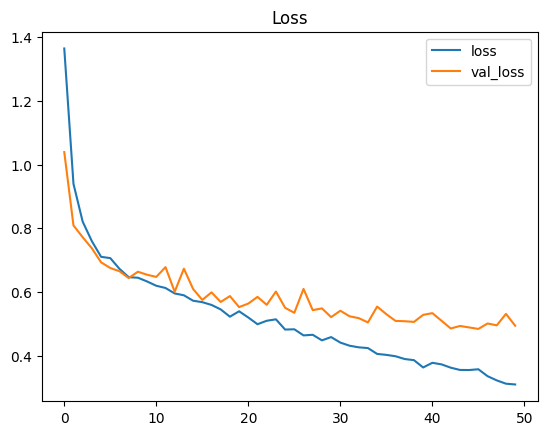

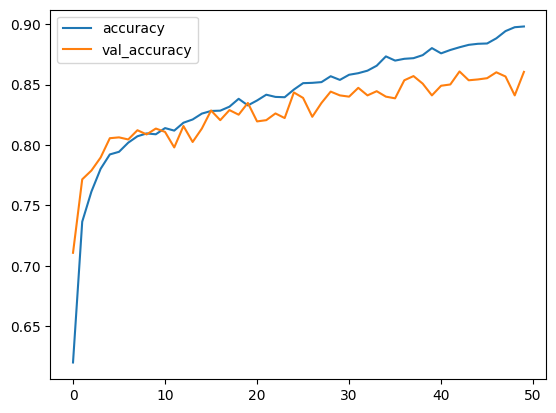

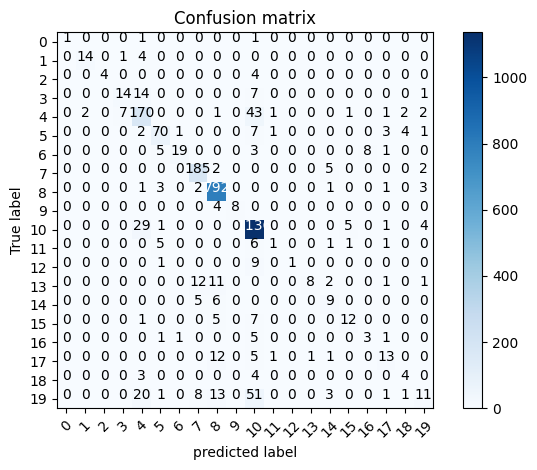

In [ ]:
if __name__ == "__main__":
    model_name = "rnn"  # can be 'cnn', 'dnn', or 'rnn'
    path = "/content/drive/MyDrive/Thesis Models/sphere.h5"
    save_directory = "/content/drive/MyDrive/Thesis Models"  # <<< You can change this directory
    sphere = models(path, save_dir=save_directory)
    print("Reading H5 file...")
    sphere.read_h5()

    if model_name == "cnn":
        sphere.cnn_model()
    elif model_name == "dnn":
        sphere.dnn_model()
    elif model_name == "rnn":
        sphere.rnn_model()

    sphere.draw()
    sphere.con_matrix()